# Section 5.2

In [2]:
import numpy as np
from tabulate import tabulate
import os
from matplotlib import pyplot as plt


In [7]:
#data import
v_sample = 62.5/2
v_sig = np.arange(.1,1.1,.1)*v_sample
v_read = np.array([3.125,
6.25,
9.346,
12.5,
15.57,
18.86,
21.93,
25,
28.15,
31.25])
signal_error = np.array([0,
0,
0.05,
0.2,
0.03,
0.06,
0,
0,
0.07,
0])
period = np.array([320,
160,
106,
80,
64,
53.6,
45.6,
40,
35.4,
32])
period_error = np.array([0,
0,
1,
0,
0,
0.6,
0,
0,
0,
0])
voltage = np.array([1.21,
1.29,
1.08,
0.0736,
0.09,
0.0436,
1.28,
1.31,
1.38,
1.5])
voltage_error = np.array([0.01,
0.01,
0.01,
0.01,
2,
2,
0,
0,
0.02,
0.01])

In [10]:
data = np.concatenate((v_sig[np.newaxis], v_read[np.newaxis], 
                      signal_error[np.newaxis], period[np.newaxis], 
                      voltage[np.newaxis]))

In [12]:
print(tabulate(data.T, headers=('nu  (MHz)','nu (on oscil) (MHz)',
                          'Signal Error (MHz)','Period (ns)',
                          'Period Error (ns)','Voltage (peak to peak) (V)'), tablefmt='grid'))

+-------------+-----------------------+----------------------+---------------+---------------------+
|   nu  (MHz) |   nu (on oscil) (MHz) |   Signal Error (MHz) |   Period (ns) |   Period Error (ns) |
+=============+=======================+======================+===============+=====================+
|       3.125 |                 3.125 |                 0    |         320   |              1.21   |
+-------------+-----------------------+----------------------+---------------+---------------------+
|       6.25  |                 6.25  |                 0    |         160   |              1.29   |
+-------------+-----------------------+----------------------+---------------+---------------------+
|       9.375 |                 9.346 |                 0.05 |         106   |              1.08   |
+-------------+-----------------------+----------------------+---------------+---------------------+
|      12.5   |                12.5   |                 0.2  |          80   |             

In [13]:
import glob

In [14]:
#Read in the files from the Lab_1_waveforms folder
samples = 16000
path    = '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_waveforms/'
files   = sorted(glob.glob(path+'*'))
data_5v    = [np.load(file)['arr_0'][:samples] for file in files]

path    = '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_waveforms_2/'
files   = sorted(glob.glob(path+'*'))
data_2v    = [np.load(file)['arr_0'][:samples] for file in files]

    

In [15]:
# normalize to propper voltages
voltage = np.array([1.21, 1.29, 1.08, 0.0736, 0.09, 0.0436, 1.28, 1.31, 1.38, 1.5])
for i, volt in zip(np.arange(0, len(data_2v)), voltage):
    data_2v[i] = data_2v[i]/data_2v[i].max()*(volt/2)
    data_5v[i] = data_5v[i]/data_5v[i].max()*(volt/2)

In [16]:
#Set up the times from the sampler
times = np.linspace(0, samples/(v_sample*1e6), samples)

In [17]:
data_5v[0].max()

0.605

<ipython-input-18-1cef13fc2105>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


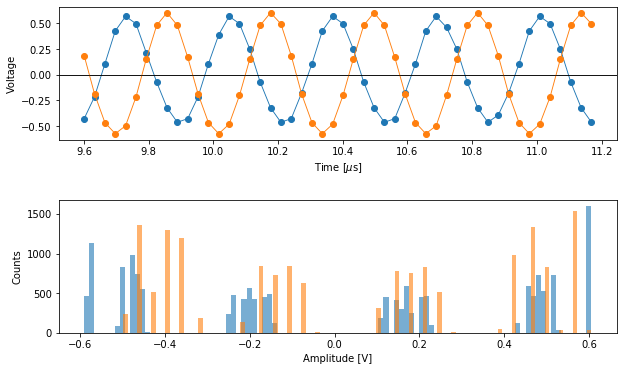

In [18]:
plot = 0
fig, (ax1, ax2) = plt.subplots(nrows=2, gridspec_kw={'hspace':.45, 'wspace':.45}, figsize=(10,6))
# ax1.set_title(str(v_sig[plot])+'MHz data at 5V range')
ax1.plot(times[300:350]*1e6, data_5v[plot][300:350], 'o-', lw = .9, alpha = 1)
ax1.set_xlabel('Time [$\mu$s]')
ax1.axhline(color='k', lw=.7)
ax1.set_ylabel('Voltage')
ax1.plot(times[300:350]*1e6, data_2v[plot][300:350], 'o-', lw = .9, alpha = 1)
ax1.axhline(color='k', lw=.7)


ax2.hist(data_2v[plot],bins=100, alpha=.6)
ax2.hist(data_5v[plot],bins=100, alpha=.6)
ax2.set_xlabel('Amplitude [V]')
ax2.set_ylabel('Counts')
plt.tight_layout()

In [19]:
#Find the period
def avg_period(data, times, nsamples=16000):
    """
    Find the average period of a sampled wave form in ns
    """
    peak = []
    for i in range(nsamples-1):
        if data[i-1] <data[i] and data[i+1] < data[i]:
            peak.append(times[i])
    T = []
    for i in range(len(peak)-1):
        T.append(peak[i+1] - peak[i])
    return np.asarray(np.mean(T))*1e9

periods_2v = np.array([avg_period(dat, times, nsamples=samples) for dat in data_2v])
periods_5v = np.array([avg_period(dat, times, nsamples=samples) for dat in data_5v])

In [20]:
periods = np.concatenate((periods_2v[np.newaxis], periods_5v[np.newaxis], period[np.newaxis]))
print(tabulate(periods.T, headers=('2V volt range periods', '5V volt range periods', 'Scope Periods'), tablefmt='grid'))

+-------------------------+-------------------------+-----------------+
|   2V volt range periods |   5V volt range periods |   Scope Periods |
+=========================+=========================+=================+
|                320.02   |                320      |           320   |
+-------------------------+-------------------------+-----------------+
|                168.59   |                160.01   |           160   |
+-------------------------+-------------------------+-----------------+
|                108.484  |                107.205  |           106   |
+-------------------------+-------------------------+-----------------+
|                 80.2232 |                 85.7999 |            80   |
+-------------------------+-------------------------+-----------------+
|                 64.004  |                 64.2369 |            64   |
+-------------------------+-------------------------+-----------------+
|                 80.198  |                 80.1855 |           

In [21]:
# power spectrum 
E_2v     = [np.fft.fft(dat) for dat in data_2v]
power_2v = [np.abs(e)**2 for e in E_2v]
E_5v     = [np.fft.fft(dat) for dat in data_5v]
power_5v = [np.abs(e)**2 for e in E_5v]
freqs = np.fft.fftfreq(len(times), np.median(np.diff(times)))


In [22]:
%matplotlib notebook

<IPython.core.display.Javascript object>


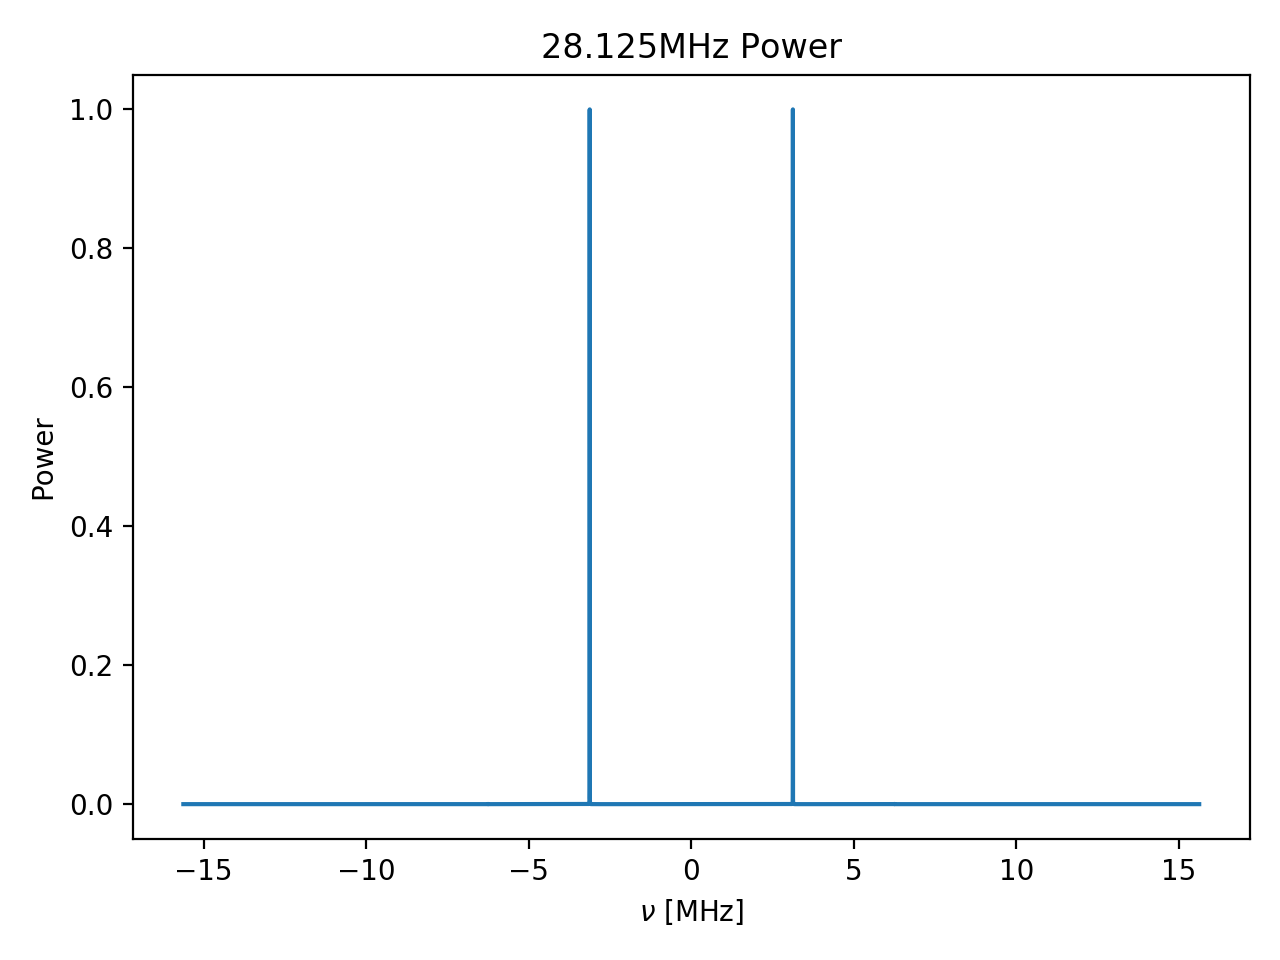

In [23]:
plot = 8
plt.figure()
plt.title(str(v_sig[plot])+'MHz Power')
plt.plot(np.fft.fftshift(freqs)/1e6, np.fft.fftshift(power_2v[plot]/power_2v[plot].max()))
# plt.plot(np.fft.fftshift(freqs)/1e6, np.fft.fftshift(power_5v[plot]/power_5v[plot].max()), ':k')
plt.xlabel(r'$\nu$'+' [MHz]')
plt.ylabel('Power')
plt.tight_layout()


# 5.3 Voltage Spectra and Power Spectra

<IPython.core.display.Javascript object>


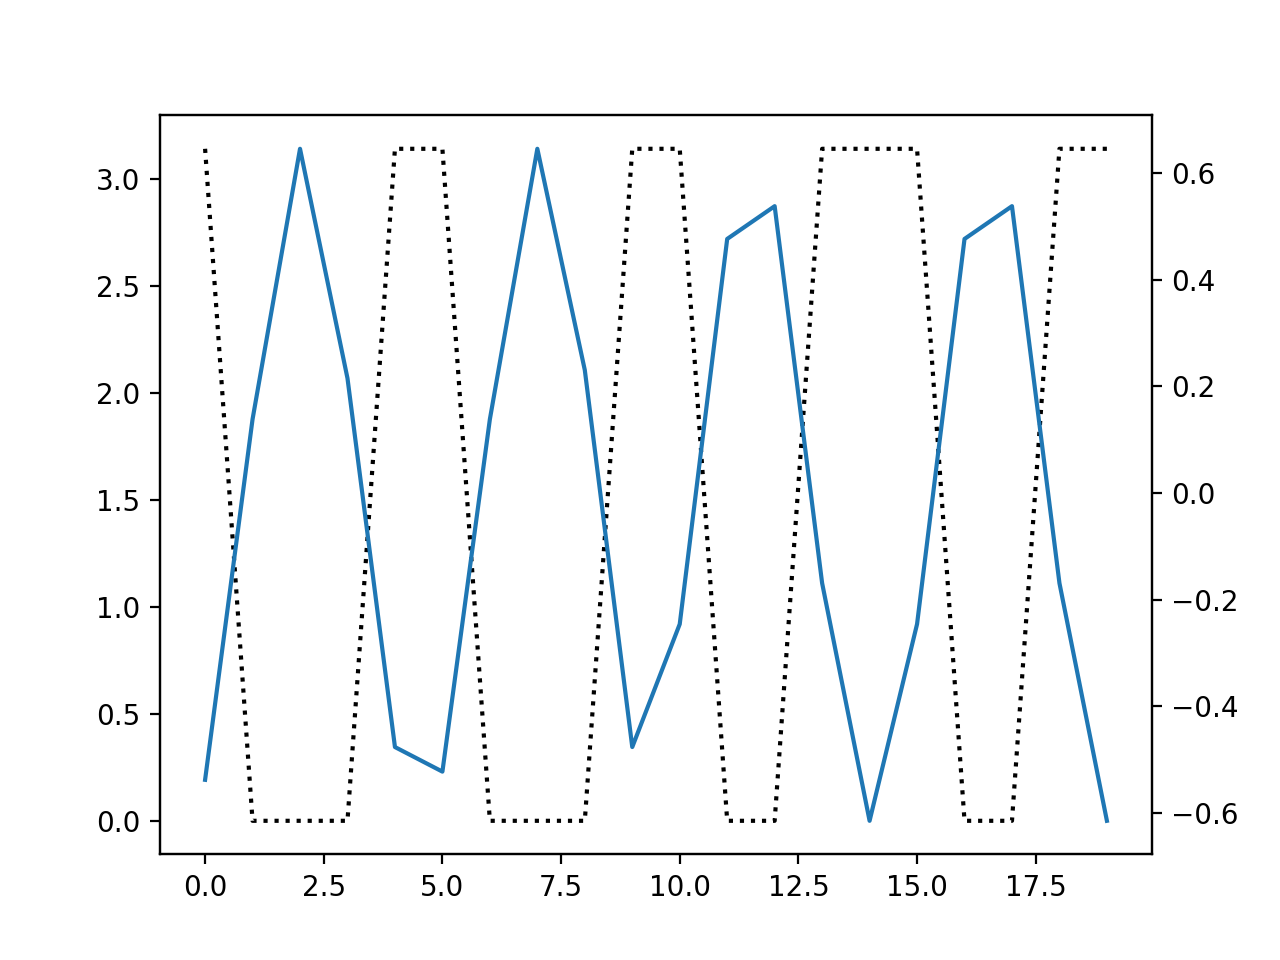

In [24]:
#Plot the real and imaginary portions
plt.figure()
# plt.plot(np.fft.fftshift(freqs), np.real(np.fft.fftshift(np.abs(np.fft.fft(data[0])))), '--k', lw=.8)
plt.plot(np.angle(data_2v[1][:20]), ':k', label='imaginary')
plt.twinx()
plt.plot(np.real(data_2v[1][:20]), label='real')

In [25]:
from scipy import correlate

In [26]:
# Auto correlation
ftpower = [np.fft.ifft(p) for p in power_2v]
ac = [np.fft.fft(dat)*np.conj(np.fft.fft(dat)) for dat in data_2v]
nac = [np.correlate(p, p, mode='same') for p in power_2v]
sac  = [correlate(p, p, mode='same') for p in power_2v]

<ipython-input-26-b32496e6f6ba>:5: DeprecationWarning: scipy.correlate is deprecated and will be removed in SciPy 2.0.0, use numpy.correlate instead
  sac  = [correlate(p, p, mode='same') for p in power_2v]


<IPython.core.display.Javascript object>


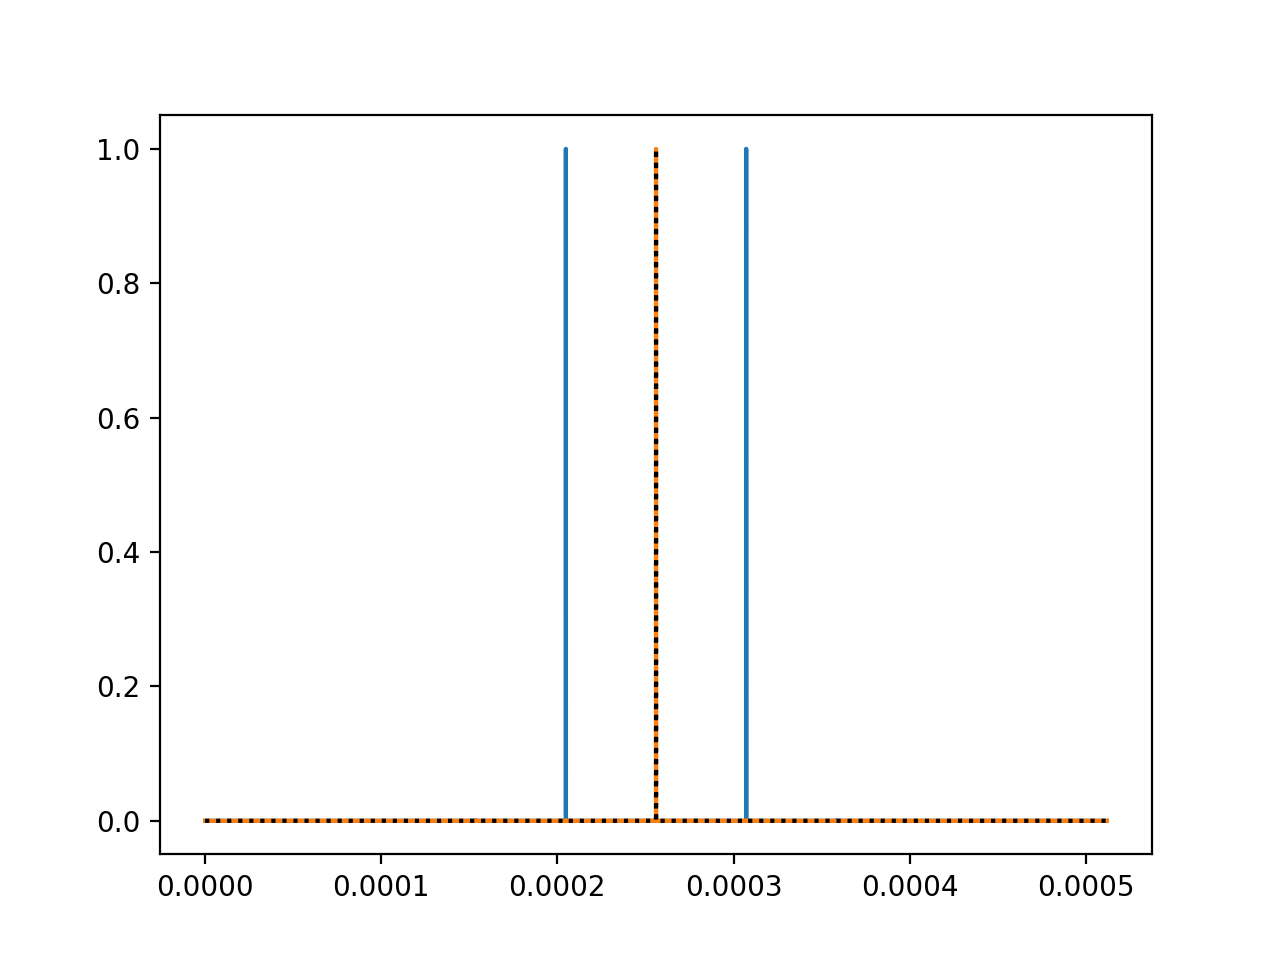

/Users/maxlee/anaconda3/envs/radio_lab/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [27]:
plt.figure()
# plt.plot(times, ftpower[0]/ftpower[0].max())
plt.plot(times, np.fft.fftshift(ac[0]/ac[0].max()))
plt.plot(times, nac[0]/nac[0].max())
plt.plot(times, sac[0]/sac[0].max(), ':k')

# 5.4 Leakage Power

In [ ]:
dft.dft()

# Frequency Resolution

In [60]:
path = '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_freq_res/'
fr_files = [file for file in sorted(glob.glob(path+'*'))]
fr_data = [np.load(file)['arr_0'] for file in fr_files]
widths = [r'$\Delta\nu$=.003MHz', r'$\Delta\nu$=.005MHz', r'$\Delta\nu$=.05MHz', r'$\Delta\nu$=.1MHz', r'$\Delta\nu$=.15MHz', r'$\Delta\nu$=2MHz']

In [61]:
fr_files

['/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_freq_res/10_10_003.npz',
 '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_freq_res/10_10_005.npz',
 '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_freq_res/10_10_05.npz',
 '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_freq_res/10_10_1.npz',
 '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_freq_res/10_10_15.npz',
 '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_freq_res/10_10_2.npz']

In [62]:
fr_power = [np.abs(np.fft.fft(dat))**2 for dat in fr_data]

In [63]:
10.05e6 - 10e6

50000.0

<IPython.core.display.Javascript object>


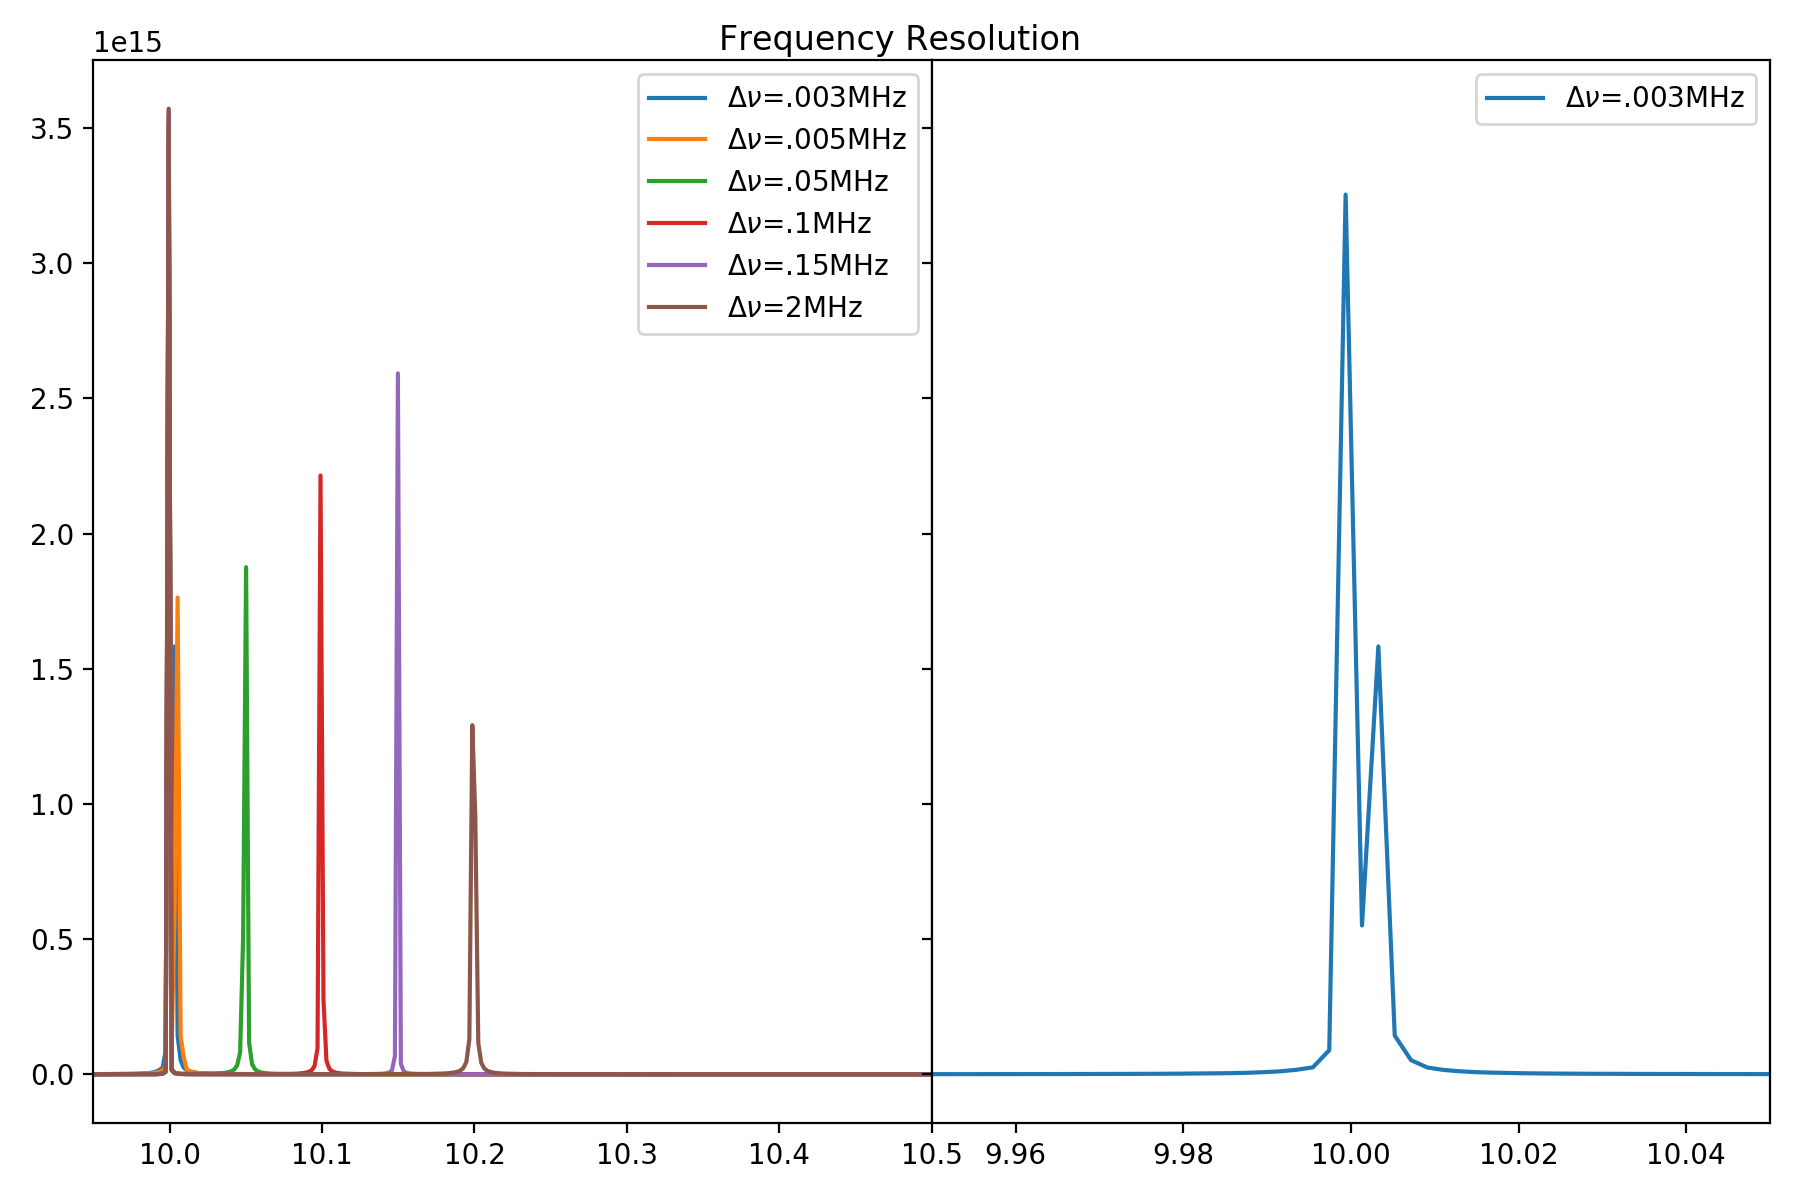

In [69]:

fig, axs = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0}, figsize=(9,6))
plt.suptitle('Frequency Resolution')
for p, width in zip(fr_power, widths):
    axs[0].plot(np.fft.fftshift(freqs)/1e6, np.fft.fftshift(p), label=width)
axs[0].set_xlim(.995e1, 1.05e1)
axs[0].legend()
axs[1].plot(np.fft.fftshift(freqs)/1e6, np.fft.fftshift(fr_power[0]), label=widths[0])
axs[1].set_xlim(.995e1, 1.005e1)
axs[1].legend()
plt.tight_layout()

## TODO ## 
* add measurements around 1kHz above base freq, our measurements are too high

In [70]:
31.25e6/(16000*2)

976.5625

# 5.6 Nyquist Window

In [71]:
import dft

In [72]:
N = 16000
v_sample /= 1e6
times = np.linspace(-N/v_sample, (N/v_sample-1)/2, N)
freqs = [np.linspace(-i*v_sample/2, i*v_sample/2*(1-2/N), N) for i in np.arange(4,8)]

In [319]:
v_sample

3.125e-05

In [320]:
nw_power = [np.abs(dft.dft(data_2v[0], t=times, f=freq, vsamp=v_sample))**2 for freq in freqs]

<IPython.core.display.Javascript object>


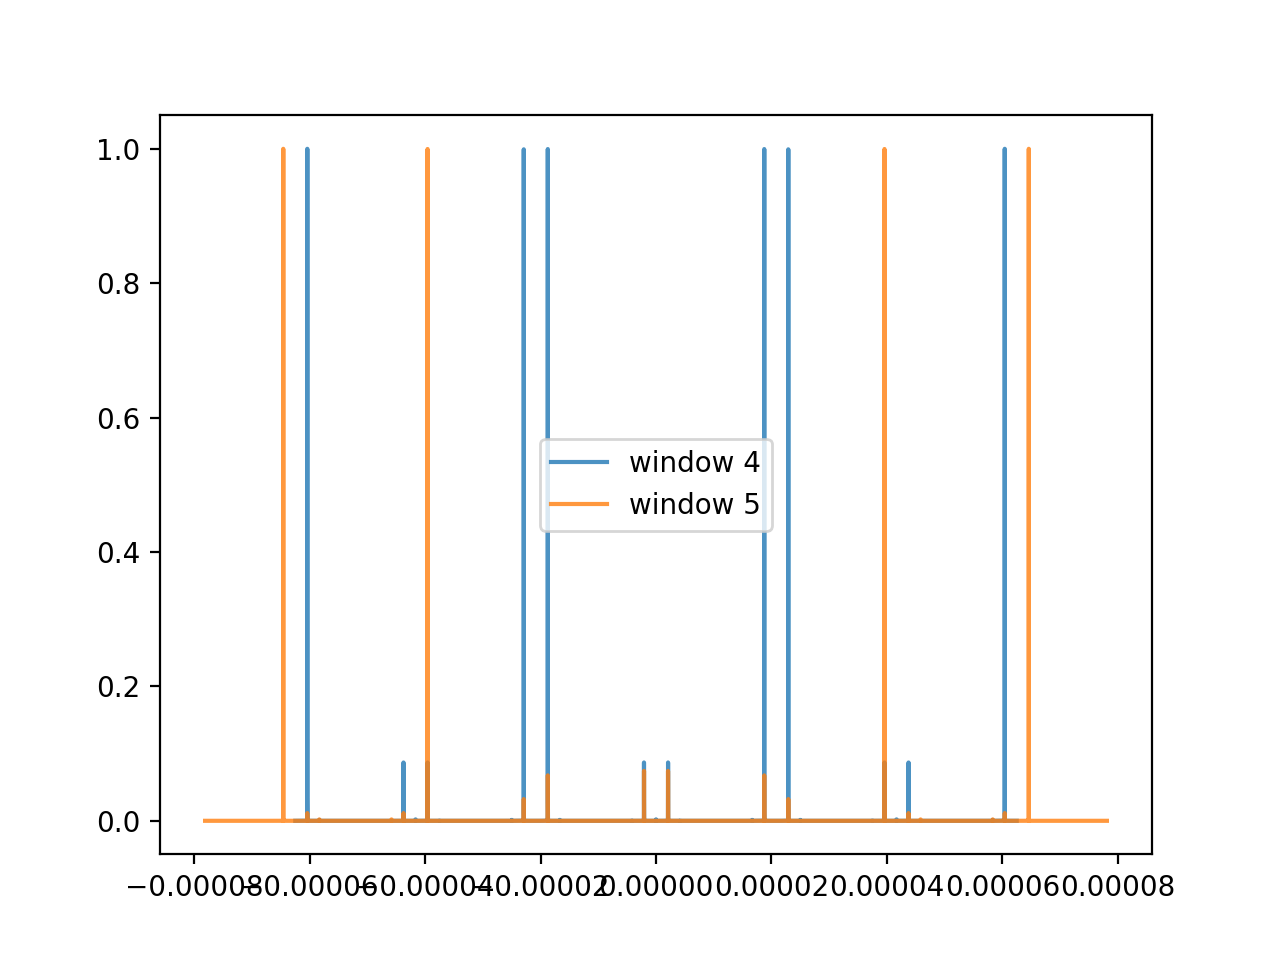

In [321]:
plt.figure()
for p, f, w, in zip(nw_power, freqs, np.arange(4,6)):
    plt.plot(f, p[1]/p[1].max(), label='window '+ str(w), alpha=.8)
plt.legend()

# 5.7 Noise in Data

TODO
Retake data with a smaller voltage range

In [93]:
path = '/Users/maxlee/Desktop/School/Radio/radio_lab/Lab_1/Lab_1_noise_data/'
files = sorted(glob.glob(path+'*'))
n_data = [np.load(file)['arr_0'] for file in files]
n_data = [dat/dat.max() for dat in n_data]

* What is the mean voltage over this sample? 
* What is the variance? 
* The standard deviation (which, for a zero-mean signal, is the same as the root-mean-square, or rms)?

In [100]:
print('Mean Voltage: ', round(n_data[0].mean(), 4))
print('Voltage Variance: ', round(n_data[0].var(), 4))
print('Voltage STD: ', round(n_data[0].std(), 4))

Mean Voltage:  -0.0224
Voltage Variance:  0.0345
Voltage STD:  0.1857


<IPython.core.display.Javascript object>


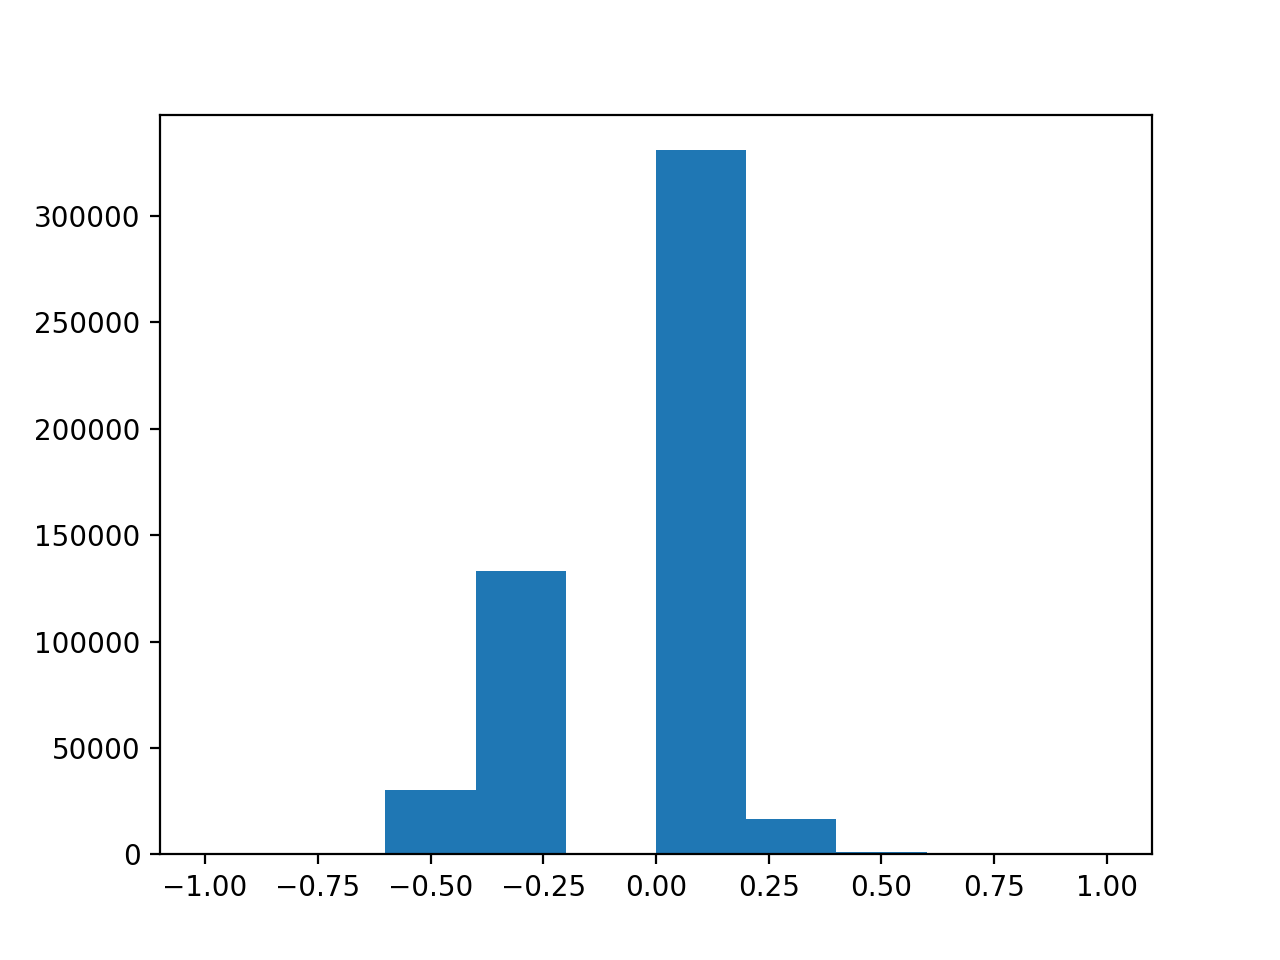

In [103]:
plt.figure()
plt.hist(n_data[0], bins=10)
plt.show()

In [107]:
blocks = np.arange(0, 16000*32,16000)

In [116]:
blocks

array([     0,  16000,  32000,  48000,  64000,  80000,  96000, 112000,
       128000, 144000, 160000, 176000, 192000, 208000, 224000, 240000,
       256000, 272000, 288000, 304000, 320000, 336000, 352000, 368000,
       384000, 400000, 416000, 432000, 448000, 464000, 480000, 496000])

In [115]:
n_data[0][:blocks[0]]

array([], dtype=float64)

In [117]:
power = []
for i in range(32):
    if i==0:
        continue
    elif i==1:
        power.append(np.abs(np.fft.fft(n_data[0][:blocks[i]]))**2)
    else:
        power.append(np.abs(np.fft.fft(n_data[0][blocks[i-1]:blocks[i]]))**2)

In [121]:
len(power[0])

16000

<IPython.core.display.Javascript object>


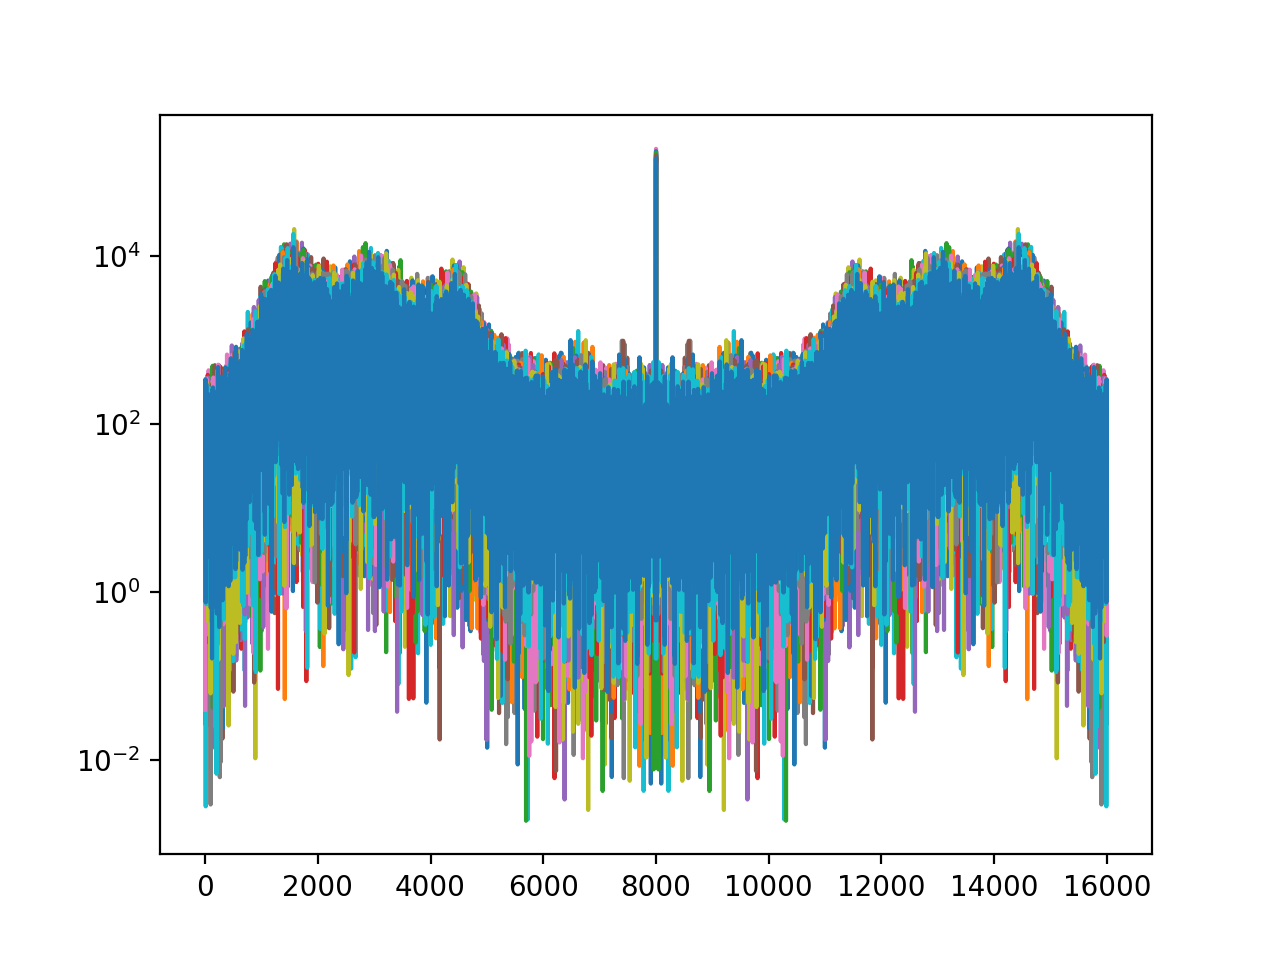

In [123]:
plt.figure()

for p in power:
    plt.plot(np.fft.fftshift(p))

In [124]:
power_mean = np.mean(power, axis=0)

<IPython.core.display.Javascript object>


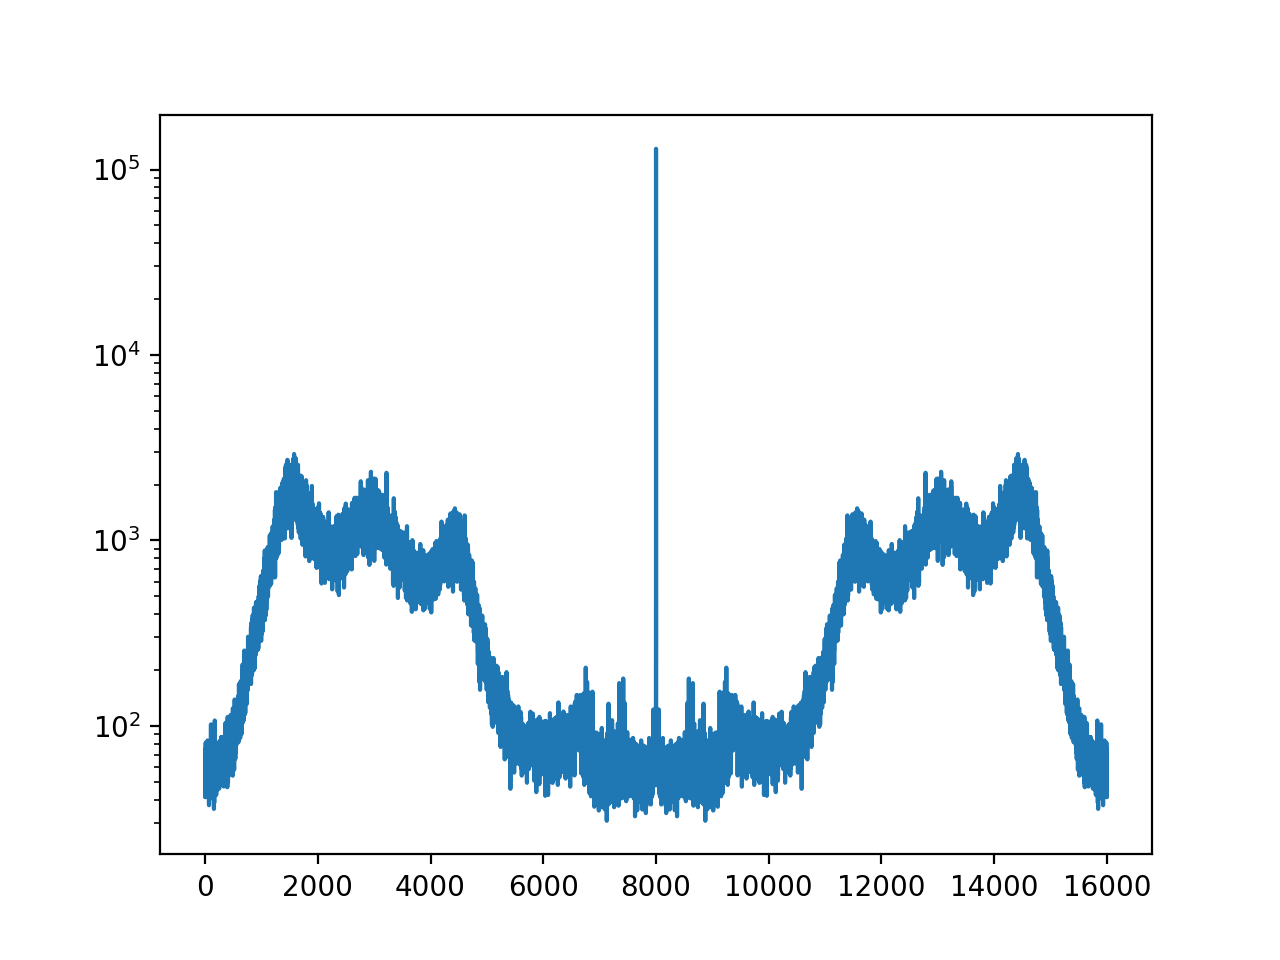

In [126]:
plt.figure()
plt.plot(np.fft.fftshift(power_mean))